In [1]:

%matplotlib inline

import math
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import time

from datetime import date, datetime, time, timedelta
from matplotlib import pyplot as plt
from pylab import rcParams
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from tqdm import tqdm_notebook


%matplotlib inline

#### Input params ##################
united = "UAL.csv"
test_size = 0.2                 # proportion of dataset to be used as test set
cv_size = 0.2                   # proportion of dataset to be used as cross-validation set
Nmax = 2                       # for feature at day t, we use lags from t-1, t-2, ..., t-N as features
                                # Nmax is the maximum N we are going to test
fontsize = 14
ticklabelsize = 14
####################################

In [2]:
def get_preds_mov_avg(df, target_col, N, pred_min, offset):
    """
    Given a dataframe, get prediction at timestep t using values from t-1, t-2, ..., t-N.
    Using simple moving average.
    Inputs
        df         : dataframe with the values you want to predict. Can be of any length.
        target_col : name of the column you want to predict e.g. 'adj_close'
        N          : get prediction at timestep t using values from t-1, t-2, ..., t-N
        pred_min   : all predictions should be >= pred_min
        offset     : for df we only do predictions for df[offset:]. e.g. offset can be size of training set
    Outputs
        pred_list  : list. The predictions for target_col. np.array of length len(df)-offset.
    """
    pred_list = df[target_col].rolling(window = N, min_periods=1).mean() # len(pred_list) = len(df)
    
    # Add one timestep to the predictions
    pred_list = np.concatenate((np.array([np.nan]), np.array(pred_list[:-1])))
    
    # If the values are < pred_min, set it to be pred_min
    pred_list = np.array(pred_list)
    pred_list[pred_list < pred_min] = pred_min
    
    return pred_list[offset:]

def get_mape(y_true, y_pred): 
    """
    Compute mean absolute percentage error (MAPE)
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [3]:
df = pd.read_csv(united)

# Convert Date column to datetime
df.loc[:, 'Date'] = pd.to_datetime(df['Date'],format='%Y-%m-%d')

# Change all column headings to be lower case, and remove spacing
df.columns = [str(x).lower().replace(' ', '_') for x in df.columns]

# Get month of each sample
df['month'] = df['date'].dt.month

# Sort by datetime
df.sort_values(by='date', inplace=True, ascending=True)

df.head(10)

,date,open,high,low,close,adj_close,volume,month
0,2015-03-30,68.250000,68.750000,67.580002,68.190002,68.190002,3393400,3
1,2015-03-31,67.949997,68.099998,66.769997,67.250000,67.250000,3272400,3
2,2015-04-01,65.059998,65.849998,63.750000,64.010002,64.010002,7428000,4
3,2015-04-02,64.239998,64.540001,61.730000,61.880001,61.880001,7559400,4
4,2015-04-06,60.639999,61.180000,59.470001,60.119999,60.119999,8067700,4
5,2015-04-07,60.580002,61.419998,59.290001,59.570000,59.570000,4870900,4
6,2015-04-08,59.849998,61.000000,59.700001,60.549999,60.549999,6791200,4
7,2015-04-09,62.259998,62.919998,60.560001,61.160000,61.160000,8906200,4
8,2015-04-10,61.290001,62.160000,61.000000,61.049999,61.049999,3731800,4
9,2015-04-13,60.570000,62.000000,60.400002,61.009998,61.009998,4808900,4


In [4]:
df['date'].min(), df['date'].max()


(Timestamp('2015-03-30 00:00:00'), Timestamp('2020-03-24 00:00:00'))

Text(0, 0.5, 'USD')

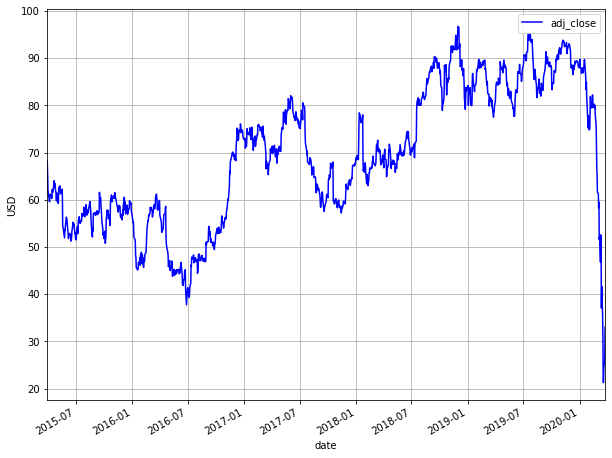

In [5]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = df.plot(x='date', y='adj_close', style='b-', grid=True)
ax.set_xlabel("date")
ax.set_ylabel("USD")


In [6]:
# Get sizes of each of the datasets
num_cv = int(cv_size*len(df))
num_test = int(test_size*len(df))
num_train = len(df) - num_cv - num_test
print("num_train = " + str(num_train))
print("num_cv = " + str(num_cv))
print("num_test = " + str(num_test))

# Split into train, cv, and test
train = df[:num_train].copy()
cv = df[num_train:num_train+num_cv].copy()
train_cv = df[:num_train+num_cv].copy()
test = df[num_train+num_cv:].copy()
print("train.shape = " + str(train.shape))
print("cv.shape = " + str(cv.shape))
print("train_cv.shape = " + str(train_cv.shape))
print("test.shape = " + str(test.shape))

num_train = 754
num_cv = 251
num_test = 251
train.shape = (754, 8)
cv.shape = (251, 8)
train_cv.shape = (1005, 8)
test.shape = (251, 8)


In [7]:
test['date'].min(), test['date'].max()


(Timestamp('2019-03-27 00:00:00'), Timestamp('2020-03-24 00:00:00'))

Text(0, 0.5, 'USD')

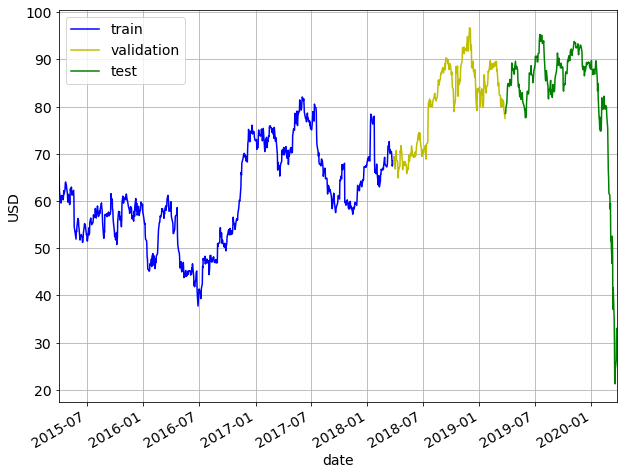

In [8]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
matplotlib.rcParams.update({'font.size': 14})

ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax.legend(['train', 'validation', 'test'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

In [9]:
RMSE = []
mape = []
for N in range(1, Nmax+1): # N is no. of samples to use to predict the next value
    est_list = get_preds_mov_avg(train_cv, 'adj_close', N, 0, num_train)
    
    cv.loc[:, 'est' + '_N' + str(N)] = est_list
    RMSE.append(math.sqrt(mean_squared_error(est_list, cv['adj_close'])))
    mape.append(get_mape(cv['adj_close'], est_list))
print('RMSE = ' + str(RMSE))
print('MAPE = ' + str(mape))
df.head()

RMSE = [1.4747315111202024, 1.598846516571656]
MAPE = [1.3353026809282804, 1.4540527925316271]


/Users/siktadas/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in less
/Users/siktadas/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in less


,date,open,high,low,close,adj_close,volume,month
0,2015-03-30,68.250000,68.750000,67.580002,68.190002,68.190002,3393400,3
1,2015-03-31,67.949997,68.099998,66.769997,67.250000,67.250000,3272400,3
2,2015-04-01,65.059998,65.849998,63.750000,64.010002,64.010002,7428000,4
3,2015-04-02,64.239998,64.540001,61.730000,61.880001,61.880001,7559400,4
4,2015-04-06,60.639999,61.180000,59.470001,60.119999,60.119999,8067700,4


Text(0, 0.5, 'RMSE')

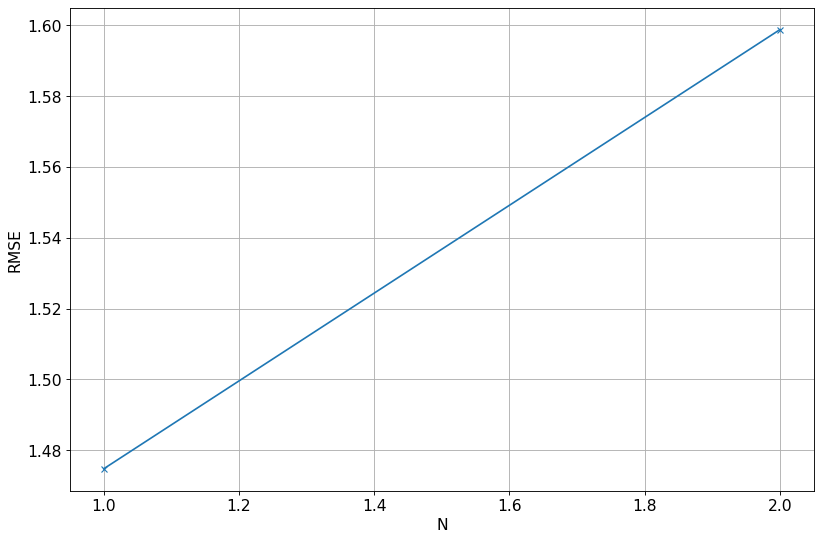

In [10]:
# Plot RMSE versus N
plt.figure(figsize=(12, 8), dpi=80)
plt.plot(range(1, Nmax+1), RMSE, 'x-')
plt.grid()
plt.xlabel('N')
plt.ylabel('RMSE')

Text(0, 0.5, 'MAPE')

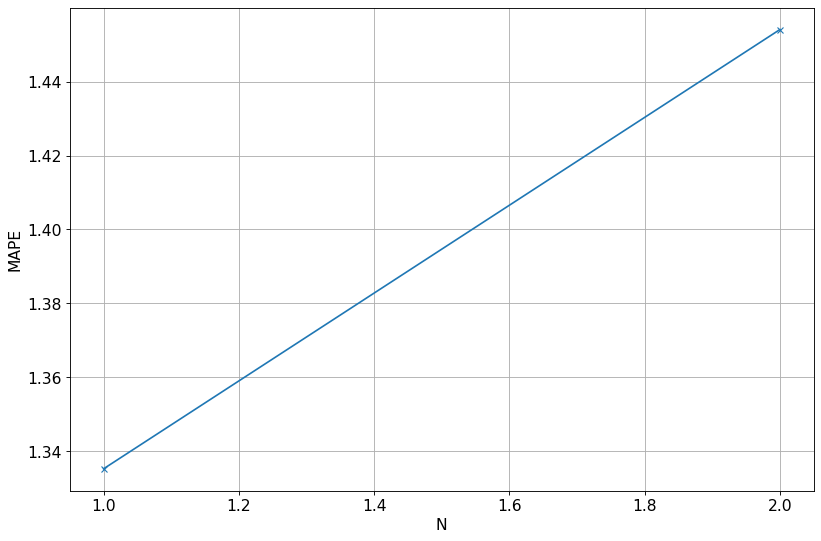

In [11]:
# Plot MAPE versus N. Note for MAPE smaller better. 
plt.figure(figsize=(12, 8), dpi=80)
plt.plot(range(1, Nmax+1), mape, 'x-')
plt.grid()
plt.xlabel('N')
plt.ylabel('MAPE')

In [12]:
# Set optimum N
N_opt = 1


Text(0, 0.5, 'USD')

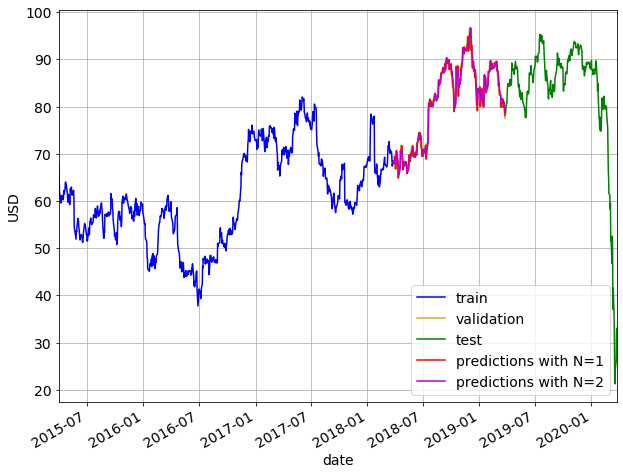

In [13]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
matplotlib.rcParams.update({'font.size': 14})

ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax = cv.plot(x='date', y='est_N1', style='r-', grid=True, ax=ax)
ax = cv.plot(x='date', y='est_N2', style='m-', grid=True, ax=ax)
ax.legend(['train', 'validation', 'test', 'predictions with N=1', 'predictions with N=2'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

In [14]:
est_list = get_preds_mov_avg(df, 'adj_close', N_opt, 0, num_train+num_cv)
test.loc[:, 'est' + '_N' + str(N_opt)] = est_list
print("RMSE = %0.3f" % math.sqrt(mean_squared_error(est_list, test['adj_close'])))
print("MAPE = %0.3f%%" % get_mape(test['adj_close'], est_list))
test.head()

RMSE = 1.964
MAPE = 1.982%


/Users/siktadas/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in less


,date,open,high,low,close,adj_close,volume,month,est_N1
1005,2019-03-27,77.540001,79.570000,77.500000,78.529999,78.529999,2371500,3,77.489998
1006,2019-03-28,78.989998,79.290001,77.779999,78.599998,78.599998,1563100,3,78.529999
1007,2019-03-29,79.050003,80.050003,78.580002,79.779999,79.779999,2449900,3,78.599998
1008,2019-04-01,80.209999,81.690002,79.559998,80.870003,80.870003,2723200,4,79.779999
1009,2019-04-02,83.190002,85.099998,82.339996,82.769997,82.769997,3795100,4,80.870003


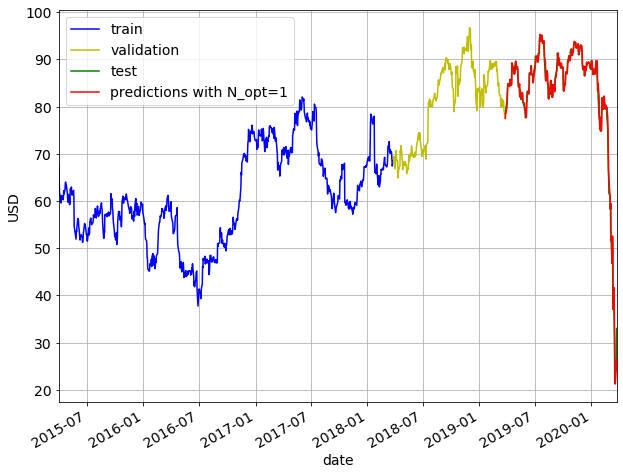

In [15]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax = test.plot(x='date', y='est_N1', style='r-', grid=True, ax=ax)
ax.legend(['train', 'validation', 'test', 'predictions with N_opt=1'])
ax.set_xlabel("date")
ax.set_ylabel("USD")
matplotlib.rcParams.update({'font.size': 14})

In [16]:
# Save as csv
test_last_value = test
test_last_value.to_csv("united_lastvalue.csv")



In [20]:
# Compare various methods
results_dict = {'Method': ['Last Value', 'Moving Average', 'LSTM'],
                'RMSE': [1.964, 2.248, 1.946],
                'MAPE(%)': [1.982, 2.981,1.776]}
results = pd.DataFrame(results_dict)
results

,Method,RMSE,MAPE(%)
0,Last Value,1.964,1.982
1,Moving Average,2.248,2.981
2,LSTM,1.946,1.776
